# 유대인 포트폴리오

| 항목  |      설명      |
|------|:----------- -:|
| 스타일 |  자산배분 |
| 기대 CAGR | -  |
| 매수 전략 | 총 자산을 다음 3개 자산에 3분의 1 씩 투자: 미국 리츠 ETF, 미국 달러화 장기국채 ETF, 코스피 ETF|
| 매도 전략 | 연 1회 리밸런싱 |

In [1]:
from lib.utils.logging import configure_logger
%load_ext autoreload
%autoreload 2
configure_logger()

## Data preparation

In [ ]:
from lib.utils.data_utils import load_data, sync_market_days

kospi_df = load_data('^KS11')
# 미국 장기채 추종 ETF
tlt_df = load_data('TLT')
# MSCI US REITs 지수
reit_df = load_data('^RMZ')

# (중요!!) 서로 다른 거래소의 종목 혹은 지수로 포트폴리오를 구성하는 경우 거래일의 교집합을 사용합니다.
kospi_df, tlt_df, reit_df = sync_market_days(kospi_df, tlt_df, reit_df)

## Develope your strategy

ch1의 lib.strategies.FixedPercentageStrategy를 재사용

## Run back-test.

In [3]:
import backtrader as bt

from lib.strategies.fixed_percentage_strategy import FixedPercentageStrategy
from lib.indicators.first_market_day_of_year import FirstMarketDayOfYear
from lib.indicators.first_market_day_of_month import FirstMarketDayOfMonth
from lib.utils.runtime_util import create_and_configure_cerebro

# Create a backtest runtime.
initial_cash = 1000000
jp_cerebro = create_and_configure_cerebro(
    FixedPercentageStrategy,
    {
        bt.feeds.PandasData(dataname=kospi_df): dict(name='KOSPI'),
        bt.feeds.PandasData(dataname=tlt_df): dict(name='TLT'),
        bt.feeds.PandasData(dataname=reit_df): dict(name='REITs')
    },
    initial_cash=initial_cash,
    strategy_params=dict(rb_ind=FirstMarketDayOfYear, buy_margin=0.02)
)

# Run it!
print('Starting Portfolio Value: %.2f' % jp_cerebro.broker.getvalue())
jp_res = jp_cerebro.run()
print('Final Portfolio Value: %.2f' % jp_cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00
Final Portfolio Value: 2874249.43


## Visualize your strategy

<IPython.core.display.Javascript object>


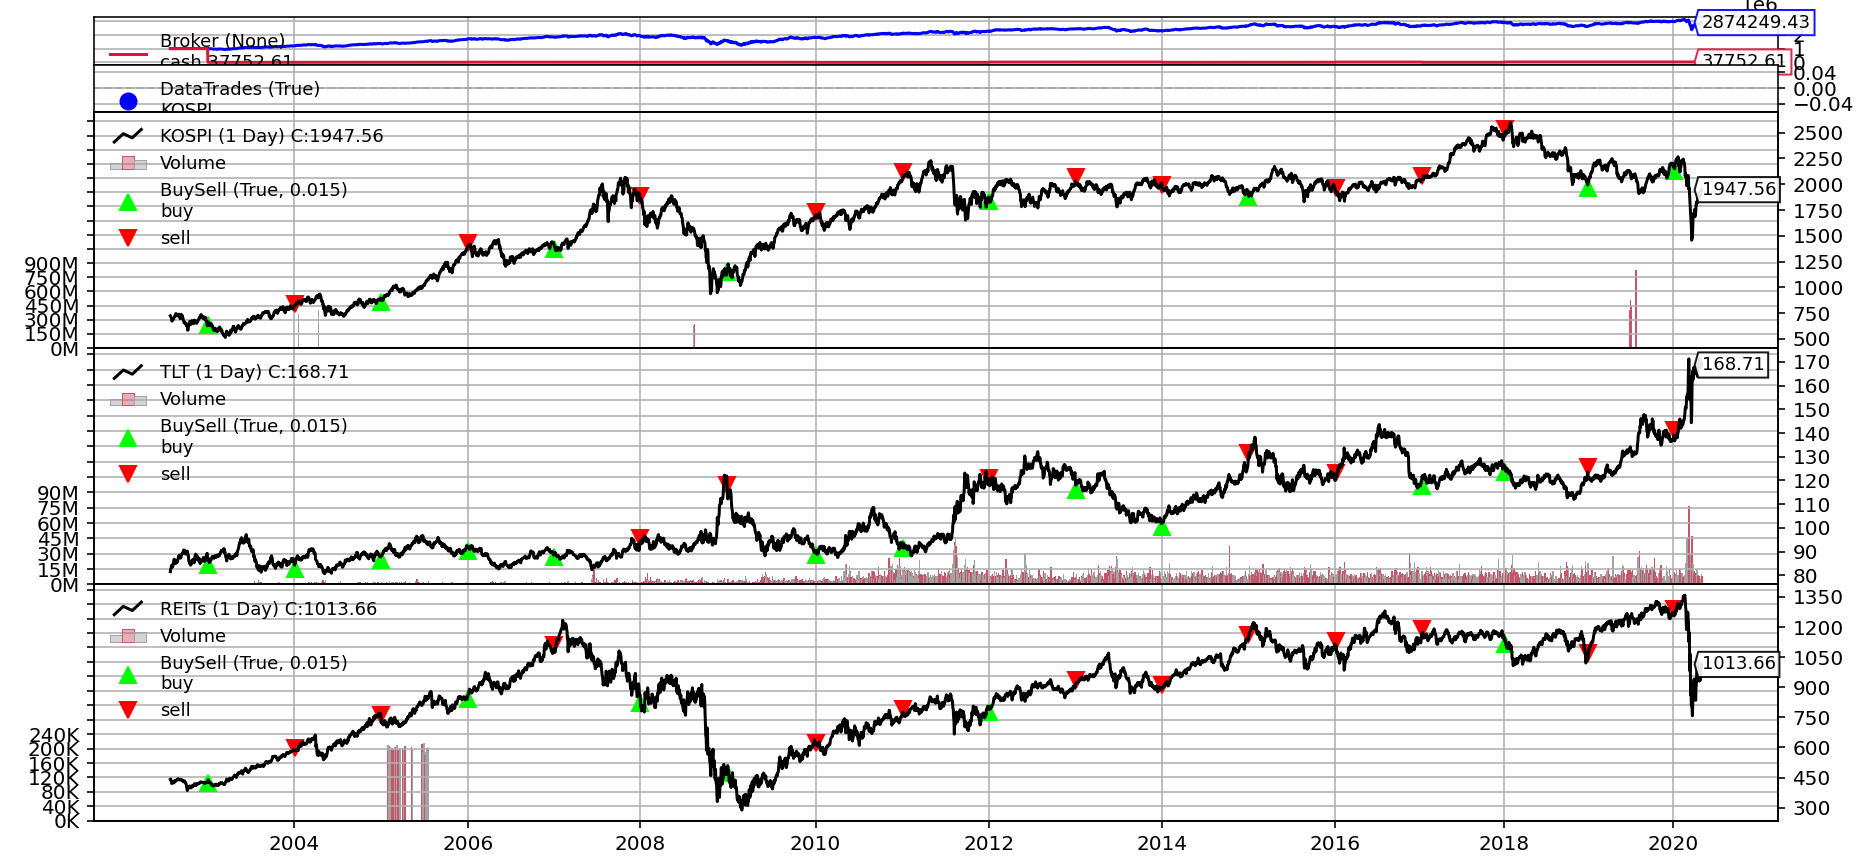

[[<Figure size 936x432 with 8 Axes>]]

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,6)
jp_cerebro.plot()

or 
## Analyze the performance by yourself.

In [5]:
%matplotlib inline
import empyrical as ep
import pandas as pd

from lib.utils.analyzer_utils import get_annual_return_analysis_df, get_pos_values_analysis_df, get_default_perf_analysis_df

pd.set_option('float_format', '{:.3f}'.format)

jp_annual_return_df = get_annual_return_analysis_df(jp_res[0])
jp_pos_values_df = get_pos_values_analysis_df(jp_res[0])
jp_perf_report_df = get_default_perf_analysis_df(jp_res[0], 'Jewish portfolio')
jp_perf_report_df

,initial_value,final_value,period_start,period_end,sharpe_ratio,mdd,cagr
Jewish portfolio,1000000.000,2874249.426,2002-07-30,2020-04-29,0.508,40.573,0.065


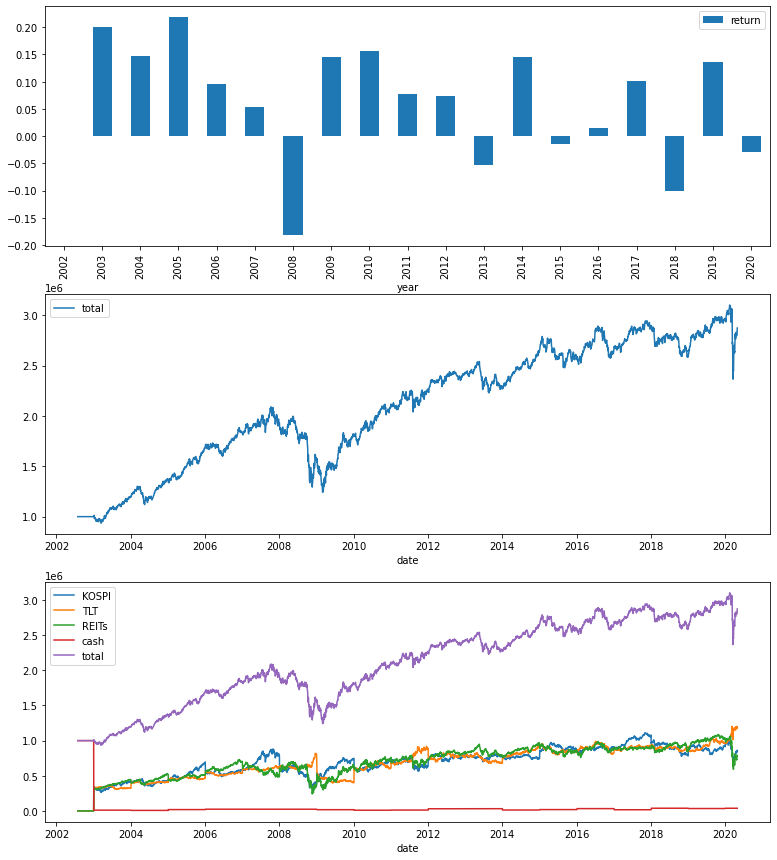

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,15)
fig = plt.figure()
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

jp_annual_return_df.plot.bar(ax=ax1)
jp_pos_values_df[['total']].plot(ax=ax2)
jp_perf_report_df.plot(ax=ax3)

# Benchmark test

1장의 정률투자법에서 동일한 기간동안 TLT(국채ETF)와 코스피지수를 보유하는 시나리오에 대해서는 이미 확인했기 때문에(아래 표 참조) 동일기간 REITs 지수 보유 시나리오만을 테스트합니다.

In [8]:
# Scenario 1
from lib.strategies.hold_all_strategy import HoldAllStrategy
from lib.utils.analyzer_utils import get_annual_return_analysis_df, get_default_perf_analysis_df, get_pos_values_analysis_df
reits_cerebro = create_and_configure_cerebro(
    HoldAllStrategy,
    {
        bt.feeds.PandasData(dataname=reit_df): dict(name='REITs'),
    },
    strategy_params=dict(buy_date='2002-07-30'),
    initial_cash=initial_cash
)

# Run it!
print('Starting Portfolio Value: %.2f' % reits_cerebro.broker.getvalue())
reits_res = reits_cerebro.run()
print('Final Portfolio Value: %.2f' % reits_cerebro.broker.getvalue())
reits_perf_report_df = get_default_perf_analysis_df(kospi_res[0], 'HoldStrategy_REITs')

Starting Portfolio Value: 1000000.00
Final Portfolio Value: 2282417.32


![Ch1_capture](ch1_screenshot.png)

In [9]:
overall_perf_report_df = pd.concat([jp_perf_report_df, reits_perf_report_df])
overall_perf_report_df

,initial_value,final_value,period_start,period_end,sharpe_ratio,mdd,cagr
Jewish portfolio,1000000.000,2874249.426,2002-07-30,2020-04-29,0.508,40.573,0.065
HoldStrategy_REITs,1000000.000,2282417.322,2002-07-30,2020-04-29,0.277,76.423,0.050


동일 기간에서 각 시나리오를 테스트 했을 때 수익률 면에서는 정률투자법을 약간 상회하는 결과를 나타냈지만 MDD의 경우 50%에 가까이 상승한 것을 볼 수 있다. 연간 리턴을 보면 책에서와 달리 굉장히 안정적이지는 않으며 적지않은 부침을 겪고 있는 것을 확인할 수 있는데 특히, 금융위기가 발생한 2008년에 -20%가까이 폭락한 것이 보인다. 

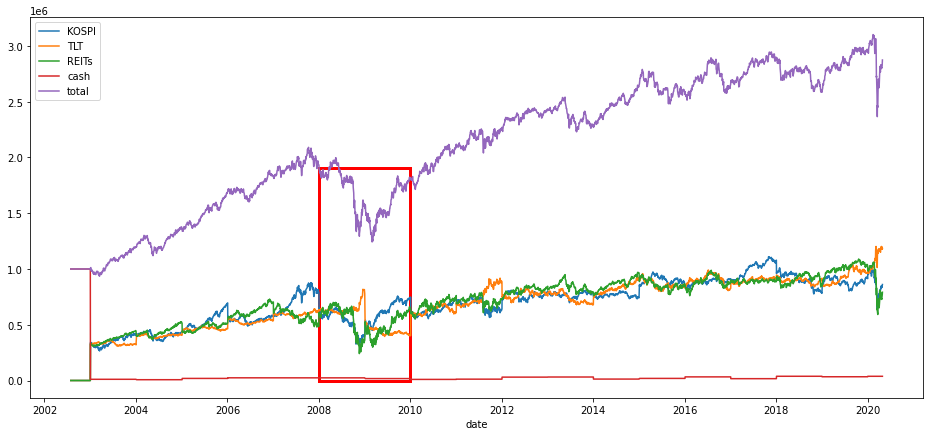

In [38]:
import matplotlib.patches as patches
from datetime import date
import matplotlib.dates as mdates

plt.rcParams["figure.figsize"] = (16,7)

fig,ax = plt.subplots(1)
jp_pos_values_df.plot(ax=ax)

start = mdates.date2num(date(2008, 1, 1))
end = mdates.date2num(date(2010, 1, 1))
width = end - start
height = jp_pos_values_df.loc[[date(2008,1,3)]]['total']

rect = patches.Rectangle((start, 0.0), width, height, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)

개별 보유 종목의 부침을 살펴보면 이 기간 REITs와 코스피 모두 개박살이 났으며 그나마 미국 장기채가 초반에 하드캐리해서 MDD를 "살짝" 감소시키는 역할을 하는 것이 보인다. 이 것은 2008년의 금융위기가 서브프라임모기지 사태에서 촉발되었으며 그 결과로 부동산 시장도 아작이났음을 감안하면 지극히 당연한 결과로 보이는데... 

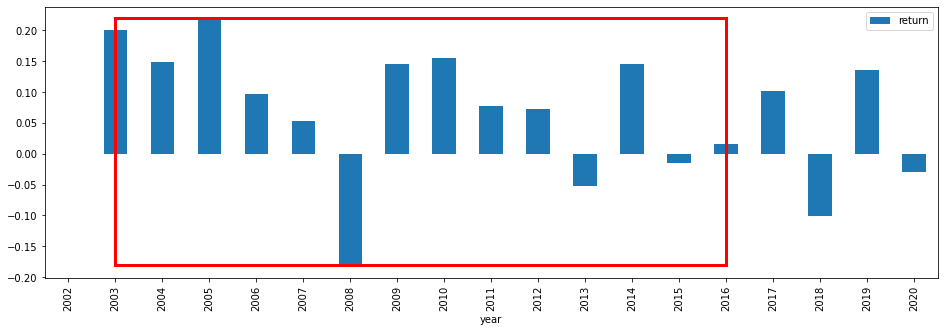

In [59]:
import matplotlib.patches as patches
from datetime import date
import matplotlib.dates as mdates

plt.rcParams["figure.figsize"] = (16,5)
fig,ax = plt.subplots(1)
jp_annual_return_df.plot.bar(ax=ax)

width = 2016 - 2003
height = jp_annual_return_df['return'].max() - jp_annual_return_df['return'].min()

rect = patches.Rectangle((1, -0.18), width, height, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)

![레알?](trueorfalse.jpeg)

책의 테스트 기간과 겹치는 기간(붉은상자)동안 각 해의 수익을 비교해 보면 추세와 절대값이 거의 일치하나 2008년 한 해에만 두드러진 차이를 보이는 것을 확인 할 수 있다. 무슨 마법을 부린걸까? 정말로 궁금하다.